In [1]:
from Environment.snake_game import SnakeGame
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import imageio # For video generation

In [41]:
class SnakeHeuristic:
    def __init__(self, game: SnakeGame):
        self.game = game
        # Map: game_direction_idx -> (row_change, col_change)
        self.delta_coords = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

    def _get_closest_apple_pos(self):
        if not self.game.apples:
            return None
        
        head_r, head_c = self.game.snake[0]
        closest_apple = None
        min_dist = float('inf')

        for apple_r, apple_c in self.game.apples:
            # Manhattan distance
            dist = abs(apple_r - head_r) + abs(apple_c - head_c)
            if dist < min_dist:
                min_dist = dist
                closest_apple = (apple_r, apple_c)
        return closest_apple

    def _is_safe_move(self, next_head_r, next_head_c):
        # 1. Check wall collision
        if not (0 <= next_head_r < self.game.height and \
                0 <= next_head_c < self.game.width):
            return False
        
        # 2. Check self-collision (with current body, excluding current head)
        # self.game.snake[0] is current head, self.game.snake[1:] is current body
        if (next_head_r, next_head_c) in self.game.snake[1:]:
            return False
            
        return True

    def choose_action(self):
        """
        Chooses an action (-1: left, 0: straight, 1: right) to move towards the closest apple.
        """
        target_apple_pos = self._get_closest_apple_pos()

        if target_apple_pos is None: # No apples on board
            return 0 # Default action: go straight

        head_r, head_c = self.game.snake[0]
        current_game_direction = self.game.direction # 0:Up, 1:Right, 2:Down, 3:Left

        candidate_actions = [] # List to store {'action': val, 'distance': dist}

        # Try actions: -1 (turn left), 0 (straight), 1 (turn right)
        for action_value in [-1, 0, 1]:
            # Determine the game direction after this action
            next_game_direction = (current_game_direction + action_value) % 4
            if next_game_direction < 0: next_game_direction += 4

            # Get change in coordinates for this game direction
            dr, dc = self.delta_coords[next_game_direction]
            
            # Calculate potential next head position
            next_head_r, next_head_c = head_r + dr, head_c + dc

            if self._is_safe_move(next_head_r, next_head_c):
                # Calculate Manhattan distance from this potential new head to the apple
                dist_to_apple = abs(target_apple_pos[0] - next_head_r) + \
                                abs(target_apple_pos[1] - next_head_c)
                candidate_actions.append({
                    'action': action_value, 
                    'distance': dist_to_apple
                })
        
        if not candidate_actions: # All potential moves are unsafe
            return 0 # Default to going straight (likely game over)

        # Sort candidates:
        # Primary: by distance to apple (ascending)
        # Secondary: prefer straight (0), then right (1), then left (-1) to break ties
        def sort_key(candidate):
            action = candidate['action']
            preference = 0 # Max preference for straight
            if action == 1: preference = 1 # Medium for right
            elif action == -1: preference = 2 # Low for left
            return (candidate['distance'], preference)

        candidate_actions.sort(key=sort_key)
        
        return candidate_actions[0]['action']

    def play_game_and_record(self, max_steps: int, video_filename: str = "snake_heuristic_game.gif", fps: int = 5):
        """
        Plays the game using the heuristic and records it as a video.
        :param max_steps: Maximum number of steps to play in the game.
        :param video_filename: Filename for the output video (e.g., "game.gif" or "game.mp4").
        :param fps: Frames per second for the video.
        """
        frames = []
        history = {
            'board': [],
            'reward': [],
            'done': -1,
            'info': []
        }
        board_state, reward, done, info = self.game.reset() # Reset game and get initial state
        
        # Convert board_state (float32, 0-1 range) to uint8 (0-255 range) for video
        frames.append((board_state * 255).astype(np.uint8))

        print(f"Starting game with heuristic. Max steps: {max_steps}. Recording to {video_filename}")

        for step_num in range(max_steps):
            history['board'].append(board_state)
            history['reward'].append(reward)
            history['info'].append(info)
            if done:
                history['done'] = step_num
                print(f"Game ended prematurely at step {step_num} before taking action. Score: {info['score']}")
                break

            action_to_take = self.choose_action()
            board_state, reward, done, info = self.game.step(action_to_take)
            
            frames.append((board_state * 255).astype(np.uint8))
            
            # Optional: print progress
            if (step_num + 1) % 100 == 0:
                 print(f"Step {step_num+1}/{max_steps}, Score: {info['score']}, Done: {done}")


            """if done:
                print(f"Game over at step {step_num+1}. Final Score: {info['score']}")
                break"""
        else: # Loop completed without break (max_steps reached)
            print(f"Game finished after {max_steps} steps (max_steps reached). Final Score: {self.game.score}")

        # Save frames as a video/gif
        if frames:
            print(f"Saving video with {len(frames)} frames at {fps} FPS...")
            try:
                imageio.mimsave(video_filename, frames, fps=fps)
                print(f"Video saved successfully as {video_filename}")
            except Exception as e:
                print(f"Error saving video: {e}")
                print("Please ensure you have an imageio backend installed (e.g., 'pip install imageio[ffmpeg]' for MP4 or 'pip install imageio pillow' for GIF).")
        else:
            print("No frames recorded.")

        return history

In [42]:
GAME_WIDTH = 20
GAME_HEIGHT = 20
FOOD_AMOUNT = 1
GRASS_GROWTH = 0.001
MAX_GRASS = 0.05
BORDER_SIZE = 1 # Add a visual border of 1 pixel
MAX_GAME_STEPS = 500 # Set a limit for the game length
VIDEO_FILENAME = "snake_ai_player.gif"
FPS = 5 # Faster for smoother video

In [43]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)

heuristic_player = SnakeHeuristic(game=game_instance)

history = heuristic_player.play_game_and_record(max_steps=MAX_GAME_STEPS, 
                                          video_filename=VIDEO_FILENAME, 
                                          fps=FPS)

Starting game with heuristic. Max steps: 500. Recording to snake_ai_player.gif
Step 100/500, Score: 10.844000000000008, Done: False
Step 200/500, Score: 22.774000000000072, Done: False
Step 300/500, Score: 34.74000000000009, Done: False
Step 400/500, Score: 45.64599999999981, Done: False
Game ended prematurely at step 410 before taking action. Score: 46.09599999999978
Saving video with 411 frames at 5 FPS...
Video saved successfully as snake_ai_player.gif


In [45]:
history['info']

[{'score': 0},
 {'score': np.float64(0.05)},
 {'score': np.float64(0.1)},
 {'score': np.float64(0.15000000000000002)},
 {'score': np.float64(0.2)},
 {'score': np.float64(0.25)},
 {'score': np.float64(0.3)},
 {'score': np.float64(1.35)},
 {'score': np.float64(1.4000000000000001)},
 {'score': np.float64(1.4500000000000002)},
 {'score': np.float64(1.5000000000000002)},
 {'score': np.float64(1.5500000000000003)},
 {'score': np.float64(1.6000000000000003)},
 {'score': np.float64(1.6500000000000004)},
 {'score': np.float64(1.7000000000000004)},
 {'score': np.float64(1.7500000000000004)},
 {'score': np.float64(1.8000000000000005)},
 {'score': np.float64(1.8500000000000005)},
 {'score': np.float64(1.9000000000000006)},
 {'score': np.float64(1.9500000000000006)},
 {'score': np.float64(2.0000000000000004)},
 {'score': np.float64(2.0500000000000003)},
 {'score': np.float64(2.1)},
 {'score': np.float64(3.1500000000000004)},
 {'score': np.float64(3.2)},
 {'score': np.float64(3.25)},
 {'score': np.f

Starting game with heuristic. Max steps: 500. Recording to snake_ai_player.gif
Game over at step 89. Final Score: 14.372000000000018
Saving video with 90 frames at 5 FPS...
Video saved successfully as snake_ai_player.gif


In [2]:
def plot_board(board,text=None):
    plt.figure(figsize=(2,2))
    plt.imshow(board)
    plt.axis('off')
    if text is not None:
        plt.gca().text(3, 3, text, fontsize=45,color = 'yellow')
    #plt.savefig(file_name,bbox_inches='tight')
    plt.show()
    plt.close()

In [23]:
game = SnakeGame(width=14, height = 14, border = 1)
board,reward,done,info = game.reset()
a = {'forw': 0, 'left': -1, 'right': 1}

In [53]:
states = {
    'board': [],
    'reward': [],
    'done': -1,
    'info': []
}

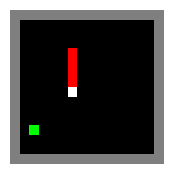

In [24]:
plot_board(board)

In [25]:
board,reward,done,info = game.step(a['left'])

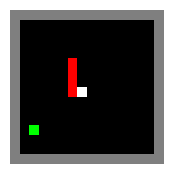

In [26]:
plot_board(board)

In [27]:
board,reward,done,info = game.step(a['right'])

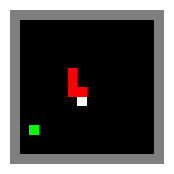

In [28]:
plot_board(board)

In [29]:
board,reward,done,info = game.step(a['right'])

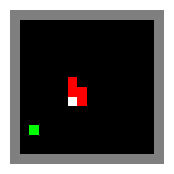

In [30]:
plot_board(board)

In [31]:
board,reward,done,info = game.step(a['forw'])

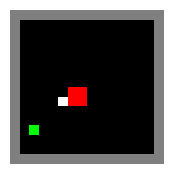

In [32]:
plot_board(board)

In [47]:
board,reward,done,info = game.step(a['forw'])

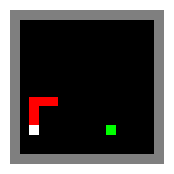

In [48]:
plot_board(board)

In [50]:
done

False